<a href="https://colab.research.google.com/github/Zoro114/mne/blob/main/XDAWN_Decoding_From_EEG_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.5 MB 4.1 MB/s 


In [46]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report ,confusion_matrix

import mne
from mne import io, pick_types, read_events, Epochs, EvokedArray, create_info
from mne.datasets import sample
from mne.preprocessing import Xdawn
from mne.decoding import Vectorizer

In [47]:
data_path=sample.data_path()
meg_path=data_path/'MEG'/'sample'
raw_fname=meg_path/'sample_audvis_filt-0-40_raw.fif'
event_fname=meg_path/'sample_audvis_filt-0-40_raw-eve.fif'
raw=mne.io.read_raw_fif(raw_fname,preload=True)
events=mne.read_events(event_fname)

Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...


In [48]:
event_id={"Auditory/Left":1,"Auditory/Right":2,"Visual/Left":3,"Visual/Right":4}
n_filter=3
raw.filter(1, 20, fir_design='firwin')
tmin,tmax=-0.1,0.3
picks=mne.pick_types(raw.info,meg=False,eeg=True,stim=False,eog=False,exclude='bads')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 497 samples (3.310 sec)



Computing rank from data with rank='full'
    EEG: rank 59 from info
    Created an SSP operator (subspace dimension = 1)
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 59 from info
    Created an SSP operator (subspace dimension = 1)
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 59 from info
    Created an SSP operator (subspace dimension = 1)
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 59 from info
    Created an SSP operator (subspace dimension = 1)
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 59 from info
    Created an SSP operator (subspace dimension = 1)
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Compu

[Text(65.40000000000006, 0.5, 'True label'),
 Text(0.5, -2.510873205539113, 'Predicted label')]

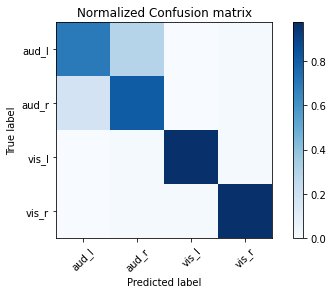

In [49]:


picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

epochs = Epochs(raw, events, event_id, tmin, tmax, proj=False,
                picks=picks, baseline=None, preload=True,
                verbose=False)

# Create classification pipeline
clf = make_pipeline(Xdawn(n_components=n_filter),
                    Vectorizer(),
                    MinMaxScaler(),
                    LogisticRegression(penalty='l1', solver='liblinear',
                                       multi_class='auto'))

# Get the labels
labels = epochs.events[:, -1]

# Cross validator
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Do cross-validation
preds = np.empty(len(labels))
for train, test in cv.split(epochs, labels):
    clf.fit(epochs[train], labels[train])
    preds[test] = clf.predict(epochs[test])

# Classification report
target_names = ['aud_l', 'aud_r', 'vis_l', 'vis_r']
report = classification_report(labels, preds, target_names=target_names)
print(report)

# Normalized confusion matrix
cm = confusion_matrix(labels, preds)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
fig, ax = plt.subplots(1)
im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(title='Normalized Confusion matrix')
fig.colorbar(im)
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
fig.tight_layout()
ax.set(ylabel='True label', xlabel='Predicted label')

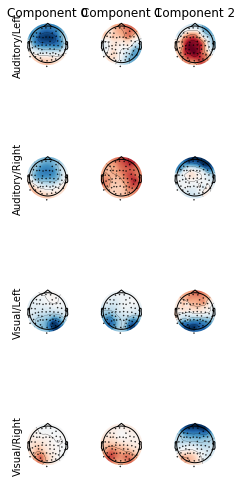

In [50]:
fig, axes = plt.subplots(nrows=len(event_id), ncols=n_filter,
                         figsize=(n_filter, len(event_id) * 2))
fitted_xdawn = clf.steps[0][1]
info = create_info(epochs.ch_names, 1, epochs.get_channel_types())
info.set_montage(epochs.get_montage())
for ii, cur_class in enumerate(sorted(event_id)):
    cur_patterns = fitted_xdawn.patterns_[cur_class]
    pattern_evoked = EvokedArray(cur_patterns[:n_filter].T, info, tmin=0)
    pattern_evoked.plot_topomap(
        times=np.arange(n_filter),
        time_format='Component %d' if ii == 0 else '', colorbar=False,
        show_names=False, axes=axes[ii], show=False)
    axes[ii, 0].set(ylabel=cur_class)
fig.tight_layout(h_pad=1.0, w_pad=1.0, pad=0.1)